In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
print(mnist.train.images[0].shape)

(784,)


In [4]:
mnist.test.labels[998]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

In [6]:
learning_rate = 0.01
training_iters = 1000  # Number of training batches
batch_size = 128       # Batch size

n_input = 784   # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
#dropout = 1.0   # Dropout, probability to keep units

x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
#keep_prob = tf.placeholder(tf.float32)             # node keeping probability

In [7]:
# Conv2D wrapper, with bias and relu activation
def conv2d(x, W, b, name, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x,name=name)

# Conv2D wrapper, with bias and relu activation
def conv2d_norelu(x, W, b, name, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b, name=name)
    return x

# MaxPool2D wrapper
def maxpool2d(x, name, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME',name=name)


# Create model
def conv_net(x, weights, biases):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1],name="reshapedInput")

    # Convolution Layer 1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'],name="conv1")
    conv1 = maxpool2d(conv1, k=2,name="maxpool1")
    print(conv1.get_shape())

    # Convolution Layer 2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'],name="conv2")
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2,name="maxpool2")
    print(conv2.get_shape())

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])

    # Output, class prediction
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'],name="last10nodes")
    return out

In [8]:
# Layer weights
weights = {
    # 5x5 conv, 1 input, 16 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 16])),
    # 5x5 conv, 32 inputs, 32 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 16, 32])),
    # fully connected, 7*7*32 inputs, 128 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*32, 128])),
    # fully connected, 128 inputs, 10 outputs
    'wd2': tf.Variable(tf.random_normal([128, 10])),
    'out': tf.Variable(tf.random_normal([10, n_classes]))
}

# Layer biases
biases = {
    'bc1': tf.Variable(tf.random_normal([16])),
    'bc2': tf.Variable(tf.random_normal([32])),
    'bd1': tf.Variable(tf.random_normal([128])),
    'bd2': tf.Variable(tf.random_normal([10])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases)
y_pred = tf.nn.softmax(logits=pred)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

(?, 14, 14, 16)
(?, 7, 7, 32)


In [ ]:
# Launch the graph
best_valid_acc=0.0

with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
                
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})

        # Set the new graph as the default.
        #with tf.Graph().as_default():
            
        if step % display_step == 0:
            # Calculate batch loss and accuracy       
            loss, acc= sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            
            valid_acc=sess.run(accuracy, feed_dict={x: mnist.test.images[:3000],
                                                   y: mnist.test.labels[:3000],
                                                   keep_prob: dropout})
            
            if (best_valid_acc<valid_acc) and (acc-valid_acc<=0.03):
                tf.train.Saver().save(sess, "/tmp/model.ckpt")
                best_valid_acc=valid_acc
            
            print("Iter " + str(step) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)+ ", Validation Accuracy= " + \
                  "{:.5f}".format(valid_acc))
        step += 1
    print("Training Finished!")

    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy after Training:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[3001:],
                                      y: mnist.test.labels[3001:],
                                      keep_prob: dropout}))
    
    tf.train.Saver().restore(sess, "/tmp/model.ckpt")
    print("Testing Accuracy Corresponding to Best Validation:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[3001:],
                                      y: mnist.test.labels[3001:],
                                      keep_prob: dropout}))
    
    #tf.train.Saver().save(sess, "/tmp/model.ckpt")

Iter 50, Minibatch Loss= 814.240356, Training Accuracy= 0.74219, Validation Accuracy= 0.71167
Iter 100, Minibatch Loss= 434.048553, Training Accuracy= 0.81250, Validation Accuracy= 0.81267
Iter 150, Minibatch Loss= 443.458588, Training Accuracy= 0.82031, Validation Accuracy= 0.85133
Iter 200, Minibatch Loss= 298.115448, Training Accuracy= 0.87500, Validation Accuracy= 0.86867
Iter 250, Minibatch Loss= 331.478882, Training Accuracy= 0.88281, Validation Accuracy= 0.87500


In [9]:
#tf.train.Saver().restore(sess, "/tmp/model.ckpt")

def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

def plot_image(image):
    # Normalize the image so pixels are between 0.0 and 1.0
    #img_norm = normalize_image(image)
    
    # Plot the image.
    #plt.imshow(img_norm, interpolation='nearest')
    #plt.imshow(image, interpolation='nearest')
    plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")
    #plt.imshow(np.reshape(image,[28,28]), cmap="gray")
    plt.show()

predicted digit of the image: 5


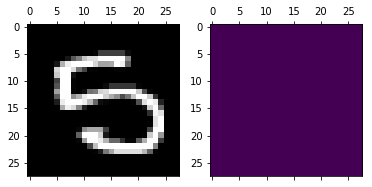

In [10]:
def createOcclusion(im,roi_size):     
    iters = (28-roi_size+1) 
    batch_size = iters**2+1
    batch = np.ndarray([batch_size, 28, 28,1])
    i = 0
    for r in range(0,iters):
        for c in range(0,iters):
            imOc = np.copy(im)
            imOc[r:r+roi_size-1,c:c+roi_size-1,0] = 0            
            batch[i] = imOc           
            i = i + 1
    batch[i] = np.copy(im)
    return batch

def softmax(w):
    w = np.array(w)
    maxes = np.amax(w, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(w-maxes) # The "max trick"
    dist = e / np.sum(e, axis=1)[:,None]
    return dist

def createOcclusionHeatMap(img,roi_size):
    with tf.Session() as sess:
        tf.train.Saver().restore(sess, "/tmp/model.ckpt")
        model=sess.graph
        occulationBatch=createOcclusion(img,roi_size)
        #print(len(occulationBatch))
        feed_dict = {x: occulationBatch.reshape(len(occulationBatch),784),keep_prob: dropout}
        y_preds, preds = sess.run([y_pred, pred],feed_dict=feed_dict)
        
        cl=np.argmax(y_preds[-1])
        print("predicted digit of the image: "+str(cl))
        org_prob=np.max(y_preds[-1])
        
        count_map=np.zeros((28,28))
        prob_map=np.zeros((28,28))
        hmdim=(28-roi_size+1)
        k=0
        for i in range(hmdim):
            for j in range(hmdim):
                prob=y_preds[k][cl]
                if prob<0.0:
                    print(preds[k])
                    print(y_preds[k])
                k+=1
                count_map[i:i+roi_size,j:j+roi_size]+=1.0
                prob_map[i:i+roi_size,j:j+roi_size]+=prob

        for i in range(28):
            for j in range(28):
                if count_map[i,j]>0:
                    prob_map[i,j]/=count_map[i,j]
                    prob_map[i,j]=1-prob_map[i,j]
        
        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].matshow(img.reshape(28,28),cmap='gray')
        pmap=axes[1].matshow(prob_map)
        #plt.colorbar(pmap,ax=axes[1])
        plt.show()
        #print(prob_map)
        
        #fig = plt.figure(figsize=(5,5))
        #fig1 = fig.add_subplot(1,2,1)
        #fig1.matshow(img.reshape(28,28),cmap='gray')
        #fig2 = fig.add_subplot(1,2,2)
        #im2=fig2.matshow(prob_map)
        #plt.colorbar(im2)
        #plt.show()
        #plt.matshow(img.reshape(28,28),cmap='gray')
        #plot_image(img)      
        #plot_image(prob_map.reshape(784))
        #plt.matshow(prob_map)
        #plt.colorbar()
        #plt.show() 

createOcclusionHeatMap(mnist.train.images[1005].reshape(28,28,1),5)

#createOcclusion(mnist.test.images[3003].reshape(28,28,1),5)
#with tf.Session() as sess:

resized_image
(?, 28, 28, 1)
(?, 14, 14, 16)
(?, 7, 7, 32)
xshape
(?, 784)
image shape
(1, 784)
before
pred1
[[ 1716.2800293   2962.16870117  9998.14941406  4468.24414062  3236.34375
    783.60974121 -4095.41259766  3299.21728516  2446.92895508
   2422.57910156]]
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]
gradient
image
(1, 784)
tensor
image shape
(1, 784)


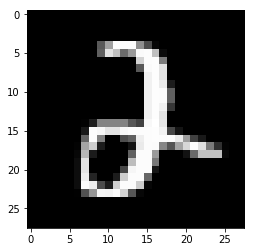

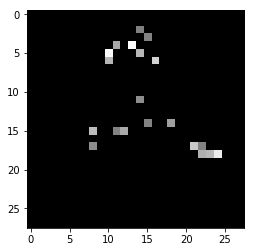

In [11]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros_like(grad))

def guided_relu_map(img,feature=0):
    """
    Find an image that maximizes the feature
    given by the conv_id and feature number.

    Parameters:
    conv_id: Integer identifying the convolutional layer to
             maximize. It is an index into conv_names.
             If None then use the last fully-connected layer
             before the softmax output.
    feature: Index into the layer for the feature to maximize.
    num_iteration: Number of optimization iterations to perform.
    show_progress: Boolean whether to show the progress.
    """

    # Load the Inception model. This is done for each call of
    # this function because we will add a lot to the graph
    # which will cause the graph to grow and eventually the
    # computer will run out of memory.
    #model = inception.Inception()
    
    with tf.Session() as sess:
        tf.train.Saver().restore(sess, "/tmp/model.ckpt")
        model=sess.graph
        
        # Reference to the tensor that takes the raw input image.
        resized_image = model.get_tensor_by_name("reshapedInput:0")
        print("resized_image")
        print(resized_image.shape)

        # Reference to the tensor for the predicted classes.
        # This is the output of the final layer's softmax classifier.
        #y_pred = model.y_pred
        #print("y_pred")
        #print(y_pred.shape)
        
        tensor = model.get_tensor_by_name("last10nodes:0")
        #tensor = model.get_tensor_by_name("last10nodes:0")
        with tf.get_default_graph().gradient_override_map({'Relu': 'GuidedRelu'}):
            #conv1 = conv2d_norelu(x, weights['wc1'], biases['bc1'],name="conv1")
            pred = conv_net(x, weights, biases, keep_prob)
            y_pred = tf.nn.softmax(logits=pred)
            
            #loss1=tf.reduce_mean(tensor[:,feature])
            #for i in range(10):
                #if i!=feature:
                    #loss1-=tf.maximum(tf.reduce_mean(tensor[:,i]),0)
            ysoft = tf.nn.softmax(logits=pred)
            #gradient = tf.gradients(tensor[0,feature], x)
            gradient = tf.gradients(pred[0,feature], x)

        # Generate a random image of the same size as the raw input.
        # Each pixel is a small random value between 128 and 129,
        # which is about the middle of the colour-range.
        image_shape = resized_image.get_shape()
        print("xshape")
        print(x.get_shape())
        image=img.reshape(1,784)
        print("image shape")
        print(image.shape)
        #print(image[0])
        #return 1

        feed_dict = {x: image.reshape(1,784),keep_prob: dropout} 
        print("before")
        t_v,y, pred1,grad = sess.run([ tensor, y_pred ,pred,gradient],feed_dict=feed_dict) 
        print("pred1")
        print(pred1)
        print(y)
        print("gradient")
        #print(grad)
        print("image")
        print(image.shape)
        print("tensor")

        print("image shape")
        print(image.shape)
        #print("grad shape")
        img=img.reshape(784)
        img1=np.abs(grad[0].reshape(784))
        img1/=np.max(img1)
        img1[img1<=0.5]=0
        '''
        for i in range(784):
            if img1[i]<=0.0 or img[i]<=0.1:
                img1[i]=0
        '''
        plot_image(image.reshape(784))
        plot_image(img1.reshape(784))

guided_relu_map(mnist.test.images[990],np.argmax(mnist.test.labels[990]))

resized_image
(?, 28, 28, 1)
(?, 14, 14, 16)
(?, 7, 7, 32)
xshape
(?, 784)
image shape
(1, 784)
before
pred1
[[  157.13807678  2714.47290039  1155.82434082  2465.80029297
    951.44024658  3025.89453125    33.35299301  -513.75793457
   -105.44784546   798.03820801]]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
gradient
image
(1, 784)
tensor
image shape
(1, 784)


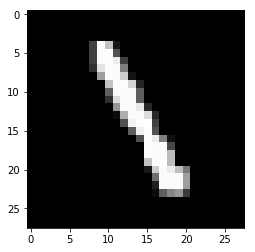

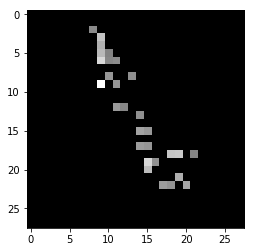

In [12]:
guided_relu_map(mnist.train.images[980],np.argmax(mnist.train.labels[980]))